In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import torch
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import neural_network_lyapunov
import neural_network_lyapunov.relu_system as relu_system
import neural_network_lyapunov.lyapunov as lyapunov
import neural_network_lyapunov.encoders as encoders
import neural_network_lyapunov.pybullet_data_generation as pybullet_data_generation
import neural_network_lyapunov.dynamics_learning as dynamics_learning

## Loading options

In [258]:
folder = "pendulum_1008"
variant = "unstable"
device = 'cuda:0'

sys.path.insert(0, os.path.join(os.path.dirname(neural_network_lyapunov.__file__), "..", "notebooks", folder))
import options
opt = dynamics_learning.DynamicsLearningOptions(options.default)
opt.set_options(options.variants[variant])

## Generating data

In [138]:
pbsg = pybullet_data_generation.PybulletSampleGenerator(opt.world_cb, opt.joint_space, image_width=opt.image_width, image_height=opt.image_height,
                                                        grayscale=opt.grayscale, dtype=opt.dtype,
                                                        camera_eye_position=opt.camera_eye_position,
                                                        camera_target_position=opt.camera_target_position,
                                                        camera_up_vector=opt.camera_up_vector)

In [139]:
x_data, x_next_data, X_data, X_next_data = pbsg.generate_dataset(opt.pybullet_x_lo, opt.pybullet_x_up, opt.dataset_dt, opt.dataset_N, opt.num_samples)

In [140]:
x_data_ = dynamics_learning.add_noise(x_data, opt.pybullet_noise)
x_next_data_ = dynamics_learning.add_noise(x_next_data, opt.pybullet_noise)
x_train_dataloader, x_validation_dataloader = dynamics_learning.get_dataloaders(x_data_, x_next_data_, opt.batch_size, opt.validation_ratio)
X_train_dataloader, X_validation_dataloader = dynamics_learning.get_dataloaders(X_data, X_next_data, opt.batch_size, opt.validation_ratio)

In [141]:
x_data_rollouts_, _, _, _ = pbsg.generate_dataset(opt.pybullet_x_lo, opt.pybullet_x_up, opt.dataset_dt, 1, opt.validation_max_rollouts)
X_rollouts, x_rollouts = dynamics_learning.data_to_rollouts(pbsg, x_data_rollouts_, opt.dataset_dt, opt.validation_rollouts_N)

In [219]:
torch.save(x_data, os.path.join(folder, "x_data"))
torch.save(x_next_data, os.path.join(folder, "x_next_data"))
torch.save(X_data, os.path.join(folder, "X_data"))
torch.save(X_next_data, os.path.join(folder, "X_next_data"))
torch.save(X_rollouts, os.path.join(folder, "X_rollouts"))
torch.save(x_rollouts, os.path.join(folder, "x_rollouts"))

In [220]:
torch.save(x_train_dataloader, os.path.join(folder, "x_train_dataloader"))
torch.save(x_validation_dataloader, os.path.join(folder, "x_validation_dataloader"))
torch.save(X_train_dataloader, os.path.join(folder, "X_train_dataloader"))
torch.save(X_validation_dataloader, os.path.join(folder, "X_validation_dataloader"))

In [ ]:
x_data = torch.load(os.path.join(folder, "x_data"))
x_next_data = torch.load(os.path.join(folder, "x_next_data"))
X_data = torch.load(os.path.join(folder, "X_data"))
X_next_data = torch.load(os.path.join(folder, "X_next_data"))
X_rollouts = torch.load(os.path.join(folder, "X_rollouts"))
x_rollouts = torch.load(os.path.join(folder, "x_rollouts"))

In [ ]:
x_train_dataloader = torch.load(os.path.join(folder, "x_train_dataloader"))
x_validation_dataloader = torch.load(os.path.join(folder, "x_validation_dataloader"))
X_train_dataloader = torch.load(os.path.join(folder, "X_train_dataloader"))
X_validation_dataloader = torch.load(os.path.join(folder, "X_validation_dataloader"))

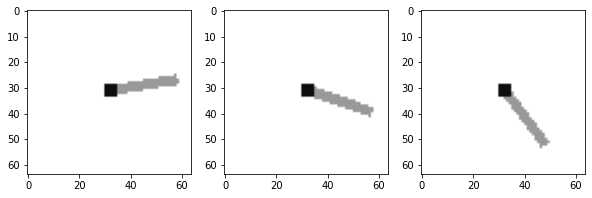

In [206]:
# plot some random sample
i = np.random.choice(X_data.shape[0], 1)[0]
pybullet_data_generation.show_sample(X_data[i,:], X_next_data[i,:])

In [ ]:
# plot some random rollout
i = np.random.choice(X_data.shape[0], 1)[0]
X_traj, x_traj = pbsg.generate_rollout(x_data[i,:], opt.dataset_dt, 5)
for n in range(X_traj.shape[0]):
    pybullet_data_generation.show_sample(X_traj[n, :])

## Learning in state space

In [ ]:
dyn_nn_model = dynamics_learning.get_ff_network(opt.dtype, opt.z_dim, opt.z_dim, opt.dyn_nn_width, opt.dyn_nn_depth)
lyap_nn_model = dynamics_learning.get_ff_network(opt.dtype, opt.z_dim, 1, opt.lyap_nn_width, opt.lyap_nn_depth)

relu_sys = relu_system.AutonomousReLUSystem(opt.dtype, opt.z_lo, opt.z_up, dyn_nn_model)
lyap = lyapunov.LyapunovDiscreteTimeHybridSystem(relu_sys, lyap_nn_model)

dyn_learner = dynamics_learning.StateSpaceDynamicsLearning(x_train_dataloader, x_validation_dataloader, relu_sys, lyap, opt)

In [ ]:
dyn_learner.train(10, validate=True)

In [ ]:
# plot some random rollout
x_traj = dyn_learner.rollout(x_data[np.random.choice(x_data.shape[0], 1)[0], :], 100)
plt.plot(x_traj)
plt.show()

In [ ]:
# validation over rollouts
dyn_learner.rollout_validation(x_rollouts)

## Learning in image space

In [269]:
dyn_nn_model = dynamics_learning.get_ff_network(opt.dtype, opt.z_dim, opt.z_dim, opt.dyn_nn_width, opt.dyn_nn_depth)
lyap_nn_model = dynamics_learning.get_ff_network(opt.dtype, opt.z_dim, 1, opt.lyap_nn_width, opt.lyap_nn_depth)

relu_sys = relu_system.AutonomousReLUSystem(opt.dtype, opt.z_lo, opt.z_up, dyn_nn_model)
lyap = lyapunov.LyapunovDiscreteTimeHybridSystem(relu_sys, lyap_nn_model)
encoder = opt.encoder_class(opt.z_dim, opt.image_width, opt.image_height, opt.grayscale)
decoder = opt.decoder_class(opt.z_dim, opt.image_width, opt.image_height, opt.grayscale)

dyn_learner = dynamics_learning.LatentSpaceDynamicsLearning(X_train_dataloader, X_validation_dataloader,
                                                            relu_sys, lyap, opt,
                                                            encoder, decoder,
                                                            use_bce=opt.use_bce, use_variational=opt.use_variational)

In [ ]:
dyn_learner.relu_system.dynamics_relu = torch.load(os.path.join(folder, variant, "dynamics"))
dyn_learner.lyapunov.lyapunov_relu = torch.load(os.path.join(folder, variant, "lyapunov"))
dyn_learner.encoder = torch.load(os.path.join(folder, variant, "encoder"))
dyn_learner.decoder = torch.load(os.path.join(folder, variant, "decoder"))

In [148]:
# pre-train encoder-decoder
import time
start = time.time()
dyn_learner.train_encoder(1000, validate=True, device=device)
end = time.time()
print(end - start)

281.12858414649963


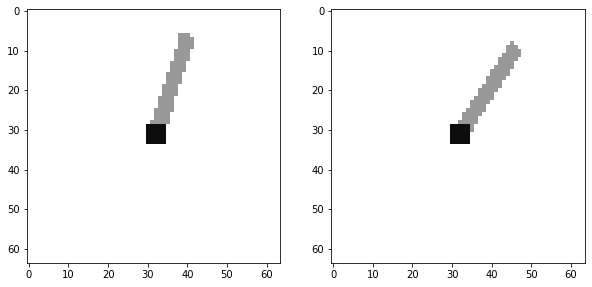

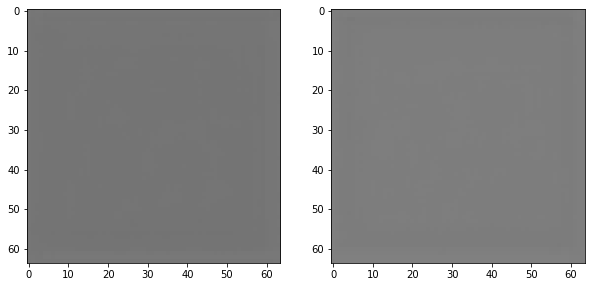

In [270]:
# plot some encoding-decoding
i = np.random.choice(X_data.shape[0], 1)[0]
pybullet_data_generation.show_sample(X_data[i,:])
X_decoded, _, _ = dyn_learner.encode_decode(X_data[i,:].unsqueeze(0))
X_decoded = X_decoded.squeeze()
pybullet_data_generation.show_sample(X_decoded)

In [225]:
# see how long verification takes
import time
start = time.time()
dyn_learner.lyapunov_loss(optimal=opt.lyapunov_loss_optimal)
end = time.time()
print(end - start)

Using license file /home/blandry/gurobi.lic
Academic license - for non-commercial use only
0.25092554092407227


In [ ]:
# train the encoder-dynamics-decoder
import time
start = time.time()
dyn_learner.train(2500, validate=True, device=device, save_rate=10, save_path=os.path.join(folder, variant))
end = time.time()
print(end - start)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267


In [ ]:
torch.save(dyn_learner.encoder, os.path.join(folder, variant, "encoder"))
torch.save(dyn_learner.decoder, os.path.join(folder, variant, "decoder"))
torch.save(dyn_learner.relu_system.dynamics_relu, os.path.join(folder, variant, "dynamics"))
torch.save(dyn_learner.lyapunov.lyapunov_relu, os.path.join(folder, variant, "lyapunov"))

In [ ]:
dyn_learner.relu_system.dynamics_relu = torch.load(os.path.join(folder, variant, "dynamics")).to('cpu')
dyn_learner.lyapunov.lyapunov_relu = torch.load(os.path.join(folder, variant, "lyapunov")).to('cpu')
dyn_learner.encoder = torch.load(os.path.join(folder, variant, "encoder")).to('cpu')
dyn_learner.decoder = torch.load(os.path.join(folder, variant, "decoder")).to('cpu')

In [181]:
X_data.shape[0] / opt.batch_size

20.0

## Some quick checks

tensor([[-9.0802, -1.4522,  2.6676]], dtype=torch.float64)
tensor([[-12.1565,  -0.5579,   2.7958]], dtype=torch.float64)
tensor([[-14.0594,   1.5967,   3.2053]], dtype=torch.float64)
tensor([[-12.2325,   3.7140,   3.6389]], dtype=torch.float64)
tensor([[-9.1409,  4.6180,  3.4124]], dtype=torch.float64)
tensor([[-4.8692,  3.2264,  2.3411]], dtype=torch.float64)
tensor([[-2.2202,  2.1572,  2.4942]], dtype=torch.float64)
tensor([[-1.6689,  1.3329,  2.3340]], dtype=torch.float64)
tensor([[-1.9083,  1.0580,  1.9864]], dtype=torch.float64)
tensor([[-3.7642,  1.4422,  3.4411]], dtype=torch.float64)
tensor([[-9.1893,  2.3514,  6.9484]], dtype=torch.float64)
tensor([[-12.4573,   1.0432,   7.3209]], dtype=torch.float64)
tensor([[-10.1342,  -0.8898,   5.7379]], dtype=torch.float64)
tensor([[-6.9457, -1.4441,  3.8649]], dtype=torch.float64)
tensor([[-6.3948, -1.6828,  3.8976]], dtype=torch.float64)
tensor([[-5.8824, -1.7899,  3.3875]], dtype=torch.float64)
tensor([[-7.3580, -2.1276,  3.2214]], dty

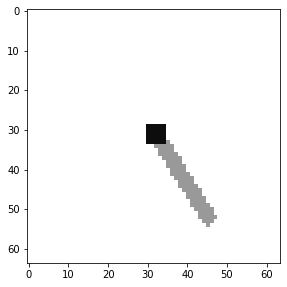

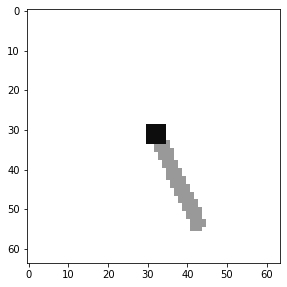

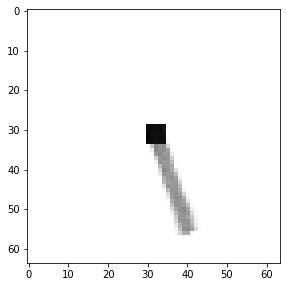

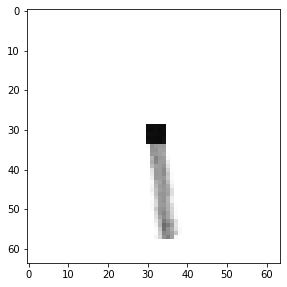

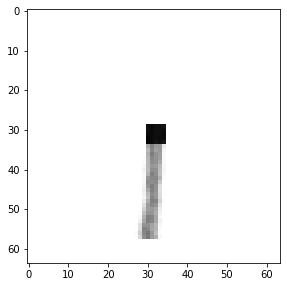

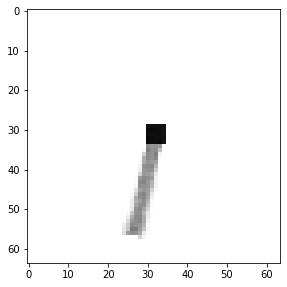

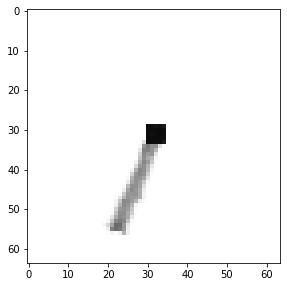

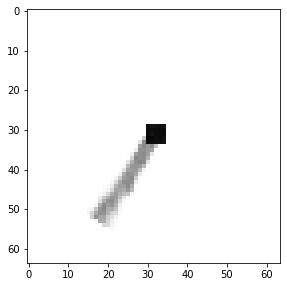

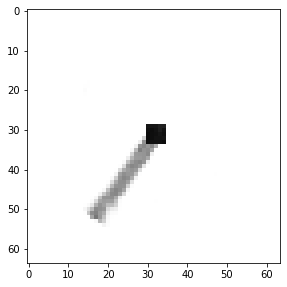

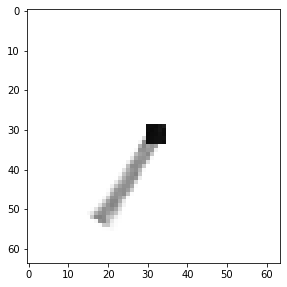

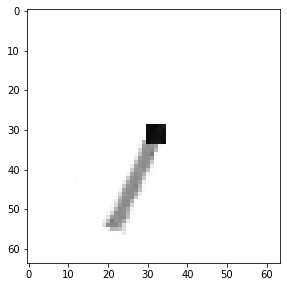

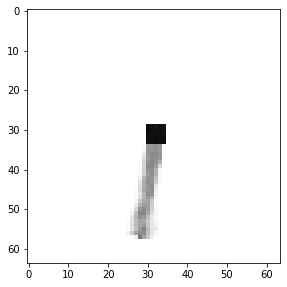

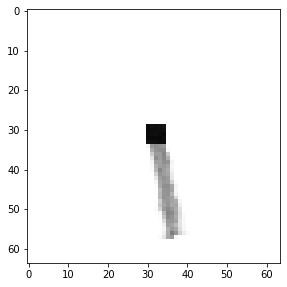

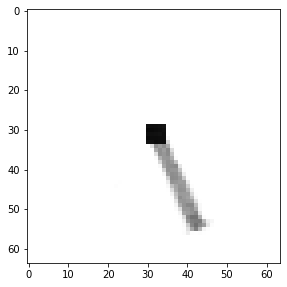

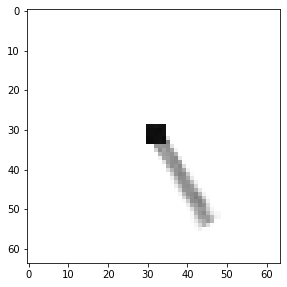

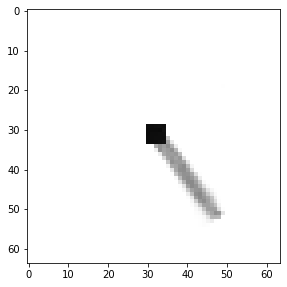

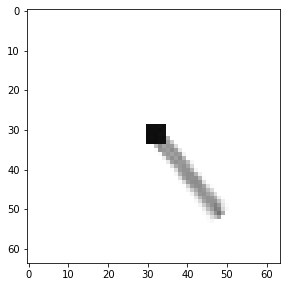

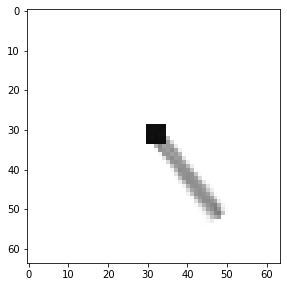

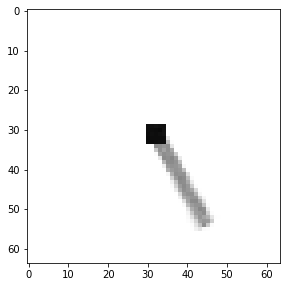

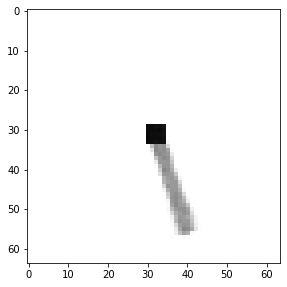

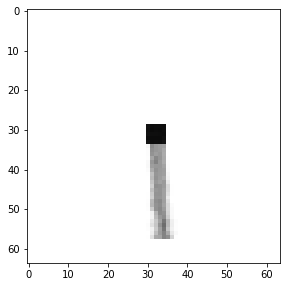

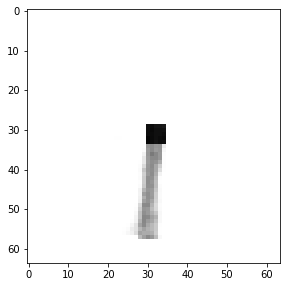

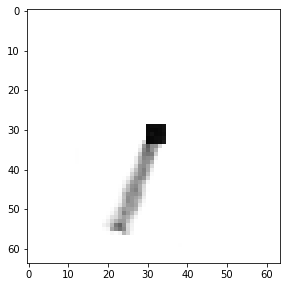

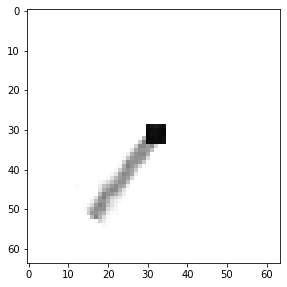

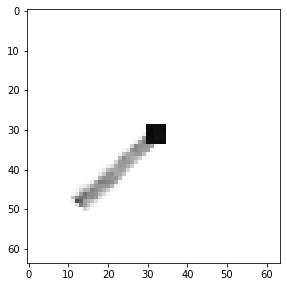

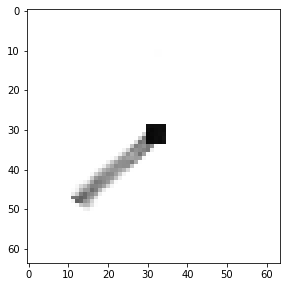

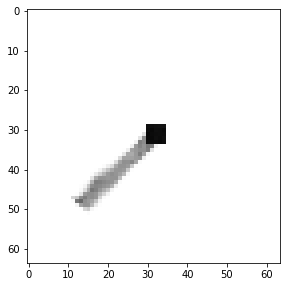

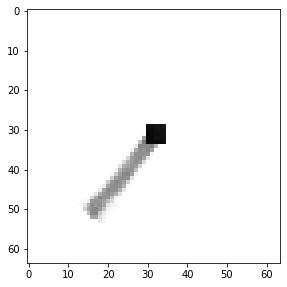

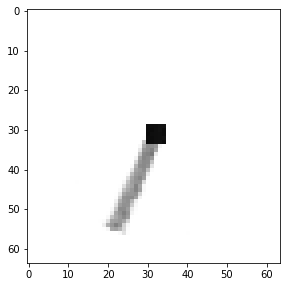

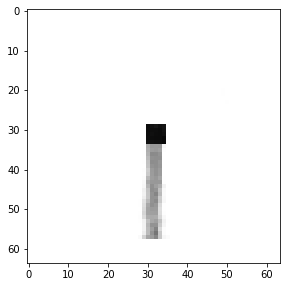

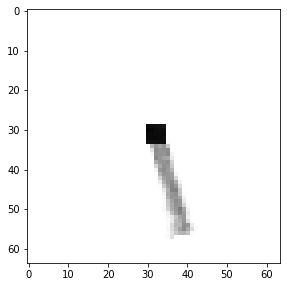

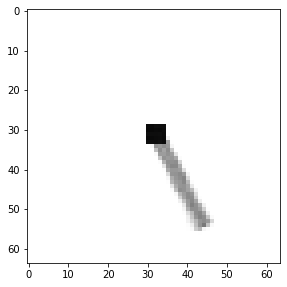

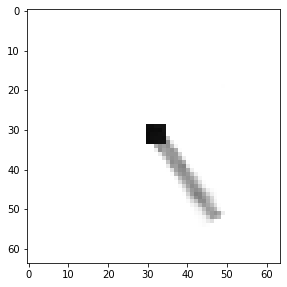

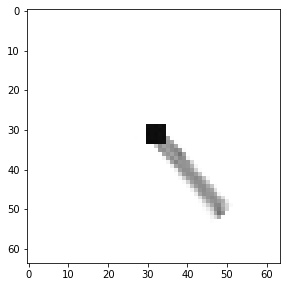

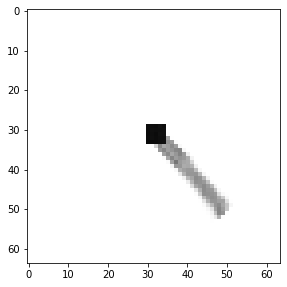

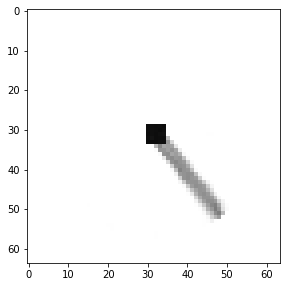

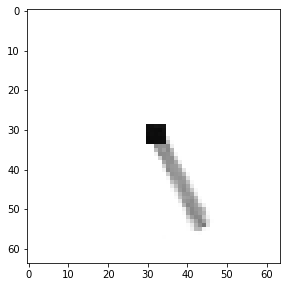

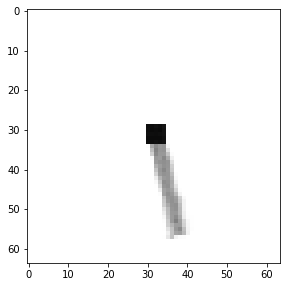

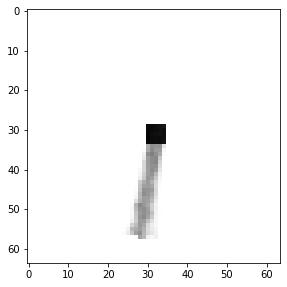

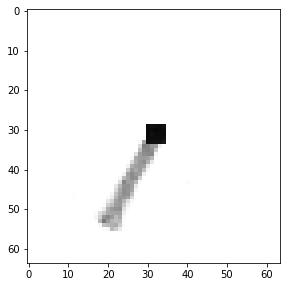

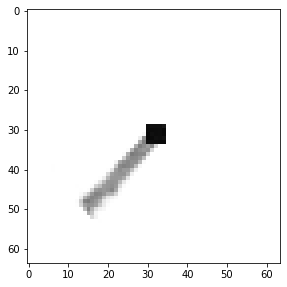

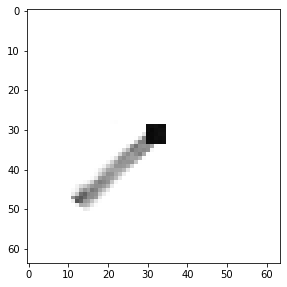

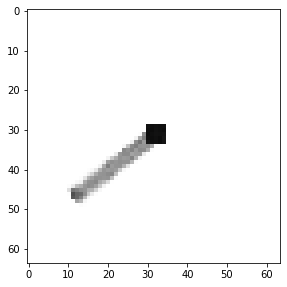

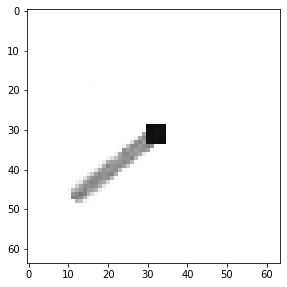

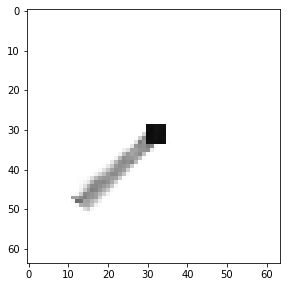

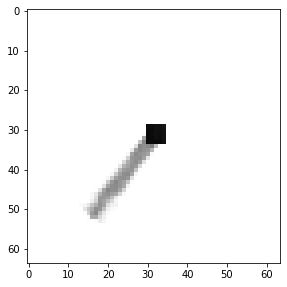

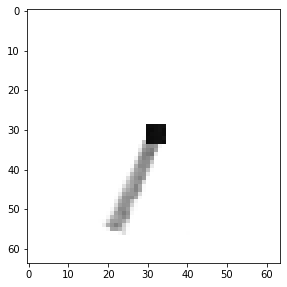

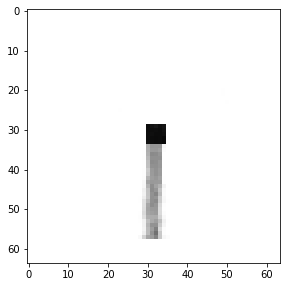

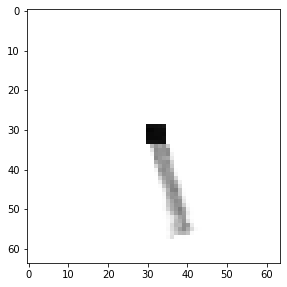

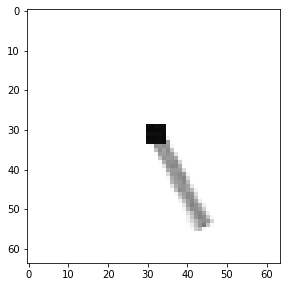

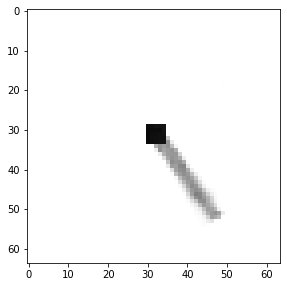

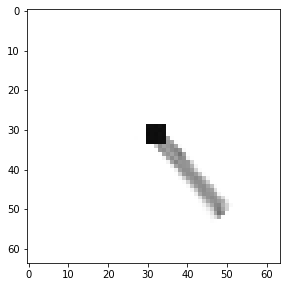

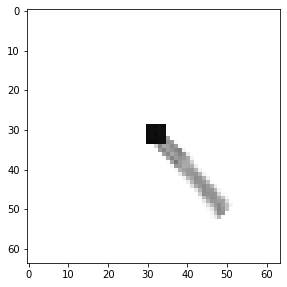

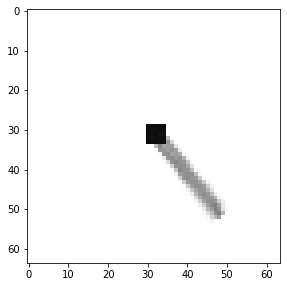

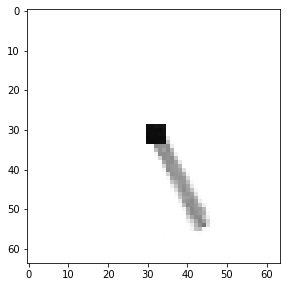

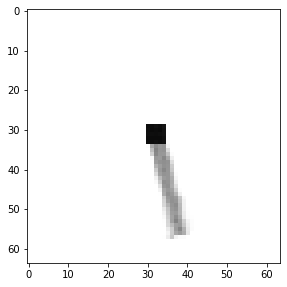

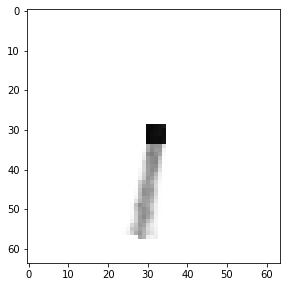

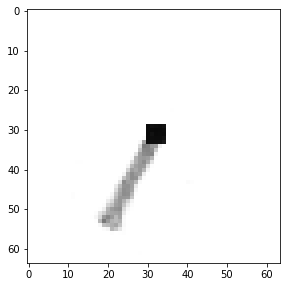

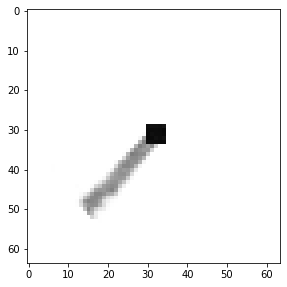

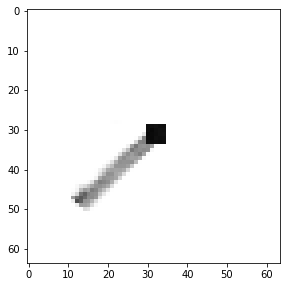

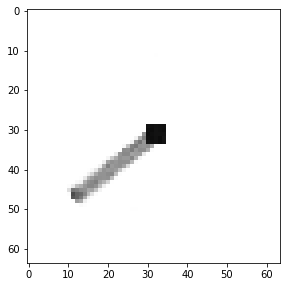

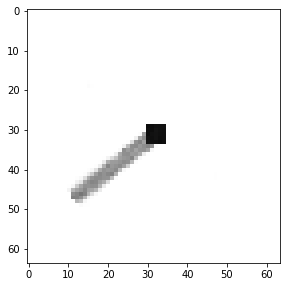

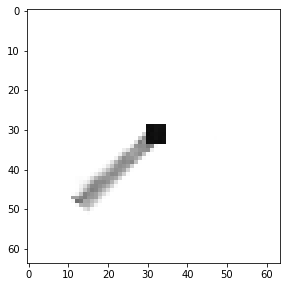

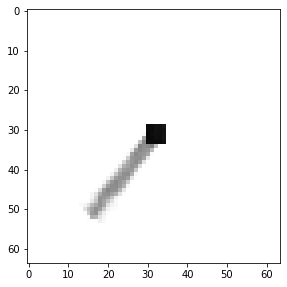

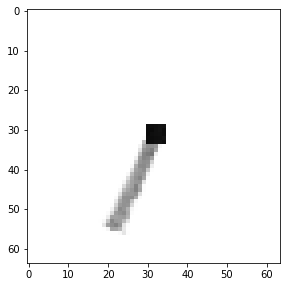

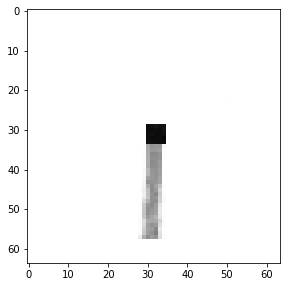

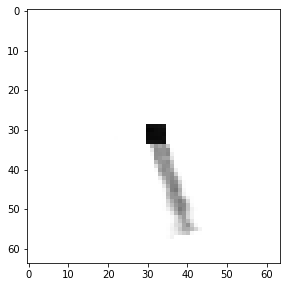

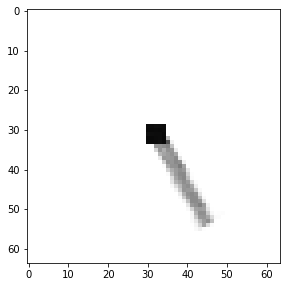

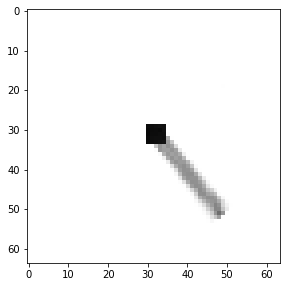

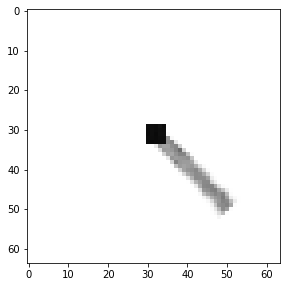

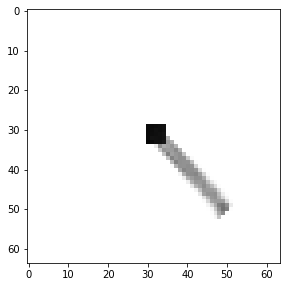

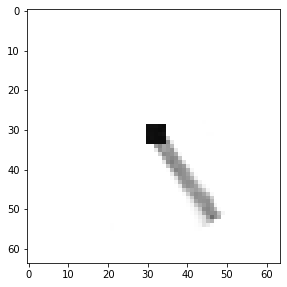

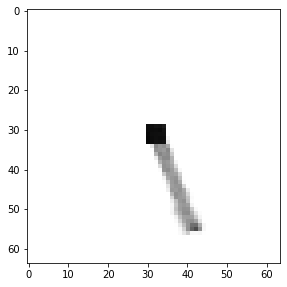

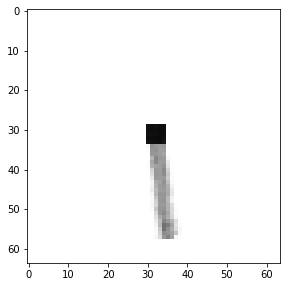

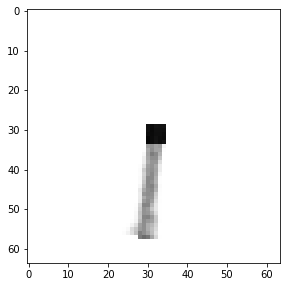

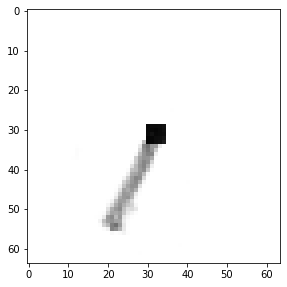

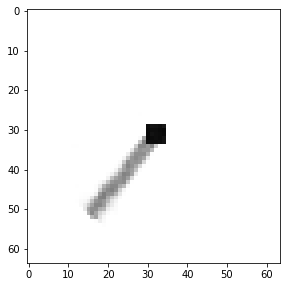

In [296]:
# plot a random rollout
i = np.random.choice(X_data.shape[0], 1)[0]
x_traj = dyn_learner.rollout(X_data[i, :], opt.validation_rollouts_N * 5)
# x_traj = dyn_learner.rollout_latent(X_data[i, :], opt.validation_rollouts_N * 5)
for n in range(x_traj.shape[0]):
    pybullet_data_generation.show_sample(x_traj[n, :])

In [ ]:
# plot the same rollout but from the real system
x_traj, _ = pbsg.generate_rollout(x_data[i, :], opt.dataset_dt, opt.validation_rollouts_N)
for n in range(x_traj.shape[0]):
    pybullet_data_generation.show_sample(x_traj[n, :])

In [ ]:
# validation over rollouts
dyn_learner.rollout_validation(X_rollouts)

In [ ]:
# computing adversarial samples
z_adv_pos, z_adv_der = dyn_learner.adversarial_samples(optimal=opt.lyapunov_loss_optimal)

In [ ]:
# rolling out the adversarial samples

# z_adv = z_adv_pos
z_adv = z_adv_der
i = np.random.choice(z_adv.shape[0], 1)[0]
X_adv = dyn_learner.decoder(z_adv[i, :].unsqueeze(0))[0, :]
pybullet_data_generation.show_sample(X_adv)

print("*****")

x_traj = dyn_learner.rollout(X_adv, opt.validation_rollouts_N)
for n in range(x_traj.shape[0]):
    pybullet_data_generation.show_sample(x_traj[n, :])